# leading and subleading leptonJet mass.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

In [23]:
import json
datasets = json.load(open('Samples/signal_4mu.json'))

from collections import defaultdict
mapping = defaultdict(list)
for k in datasets:
    mapping[k.split('_')[0]].append(k)

In [25]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        mass0_axis = hist.Bin("mass0", "invM(lead, sublead) leptonJets [GeV]", 50, 0, 200)
        mass1_axis = hist.Bin("mass1", "invM(lead, sublead) leptonJets [GeV]", 50, 0, 1200)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. #counts/4GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. #counts/24GeV", dataset_axis, mass1_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            mass_ = leadingLjPair.mass
            
            output['mass0'].fill(dataset=dataset, mass0=mass_.flatten())
            output['mass1'].fill(dataset=dataset, mass1=mass_.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [26]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=6, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 160/160 [00:08<00:00, 19.86items/s]


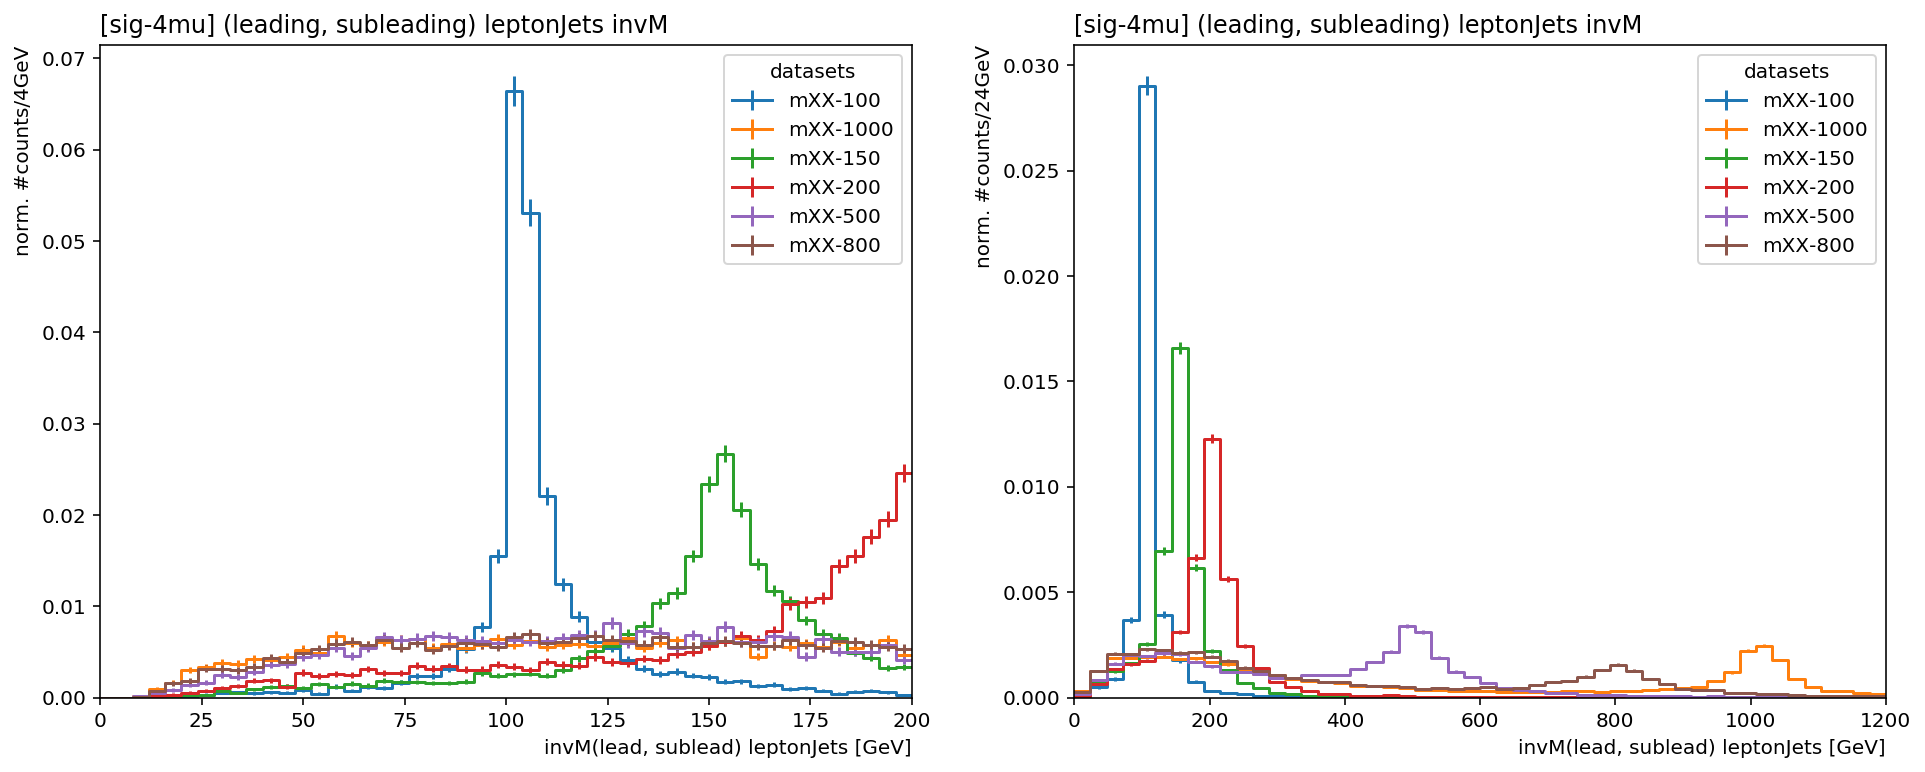

In [27]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['mass0'], overlay='cat', density=True, ax=axes[0])
hist.plot1d(output['mass1'], overlay='cat', density=True, ax=axes[1])

for ax in axes:
    ax.set_title('[sig-4mu] (leading, subleading) leptonJets invM', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

---